# Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal

# g(t) analysis

The following equation derived by _Menoni, et al_, explains how the sample is received, according the $k$-th bit from the $m$-th pixel value $b^k_m$, assuming the tempest capture (tuning an SDR at pixel rate, sampling with $T_s=\frac{1}{fs}$):

$$
y[n T_s] = \sum_{m=0}^{N \times M-1}\sum_{k=0}^{9}b_m^k g(nT_s - kT_b - mT_p)
$$

Where the transmitting image sized $M \times N$ (including blanking). $T_p = T_b / 10$ is the pixel transmition timing.

The function $g(t)$ corresponds to the convolution of the complex baseband representation of the transmitting pulse (at pixel harmonic frequency $f_h$) with the SDR's low pass filter (LPF):

$$
g(t) = \mathcal{F}^{-1} \left\{ P(f-f_h) \Pi(f/f_{LPF})\right\}
$$

In [2]:
#funcion que toma como entrada el armonico a sintonizar y las dimensiones de la imagen a espiar y devuelve un array con taps de g(t)
def g_taps(dim_vertical, dim_horizontal, armonico):

    #defino variables iniciales
    f_b = 10 * (dim_vertical * dim_horizontal * 60)
    f_sdr = 50e6
    harm = armonico * f_b
    
    #para el correcto funcionamiento: dependiendo del armonico, elijo cuantas muestras por pulso
    if (armonico < 5 ):
        muestras_por_pulso  = 10
    else:
        muestras_por_pulso  = 20

    samp_rate = muestras_por_pulso * f_b
    H_samples = dim_horizontal * muestras_por_pulso

    #creo el pulso
    t_continuous = np.linspace(start = 0, stop = H_samples/samp_rate, num = H_samples, endpoint= False)
    pulso = np.zeros(H_samples)
    pulso[:muestras_por_pulso] = 0.7/255

    #traslado el espectro del pulso el armonico correspondiente
    frec_armonico = np.exp(-2j*np.pi*harm*t_continuous)
    pulso_complejo = pulso*frec_armonico

    #creo el lpf del sdr
    b, a = signal.butter(6, f_sdr/2, fs=samp_rate, btype='lowpass', analog=False)

    #filtro con lpf el pulso multiplicado por armonico. El resultado es g
    g_t = signal.lfilter(b, a, pulso_complejo)

    # si arminico crece, necesito mas taps
    if (armonico < 5):
        g_t = g_t[:1500]
    else:
        g_t = g_t[:3000]

    g_t_max = np.max(np.abs(g_t))
    g_t = g_t / g_t_max

    return g_t

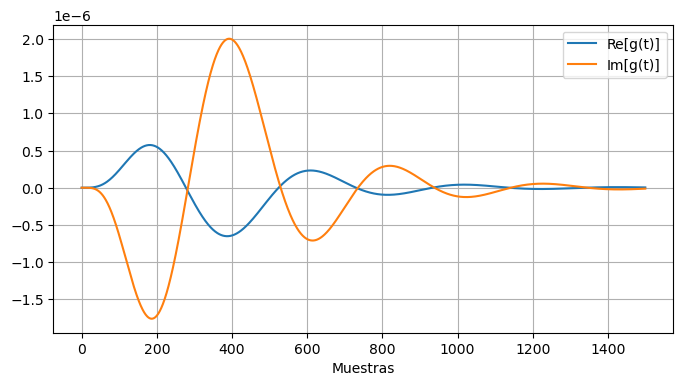

In [3]:
g_t = g_taps(1280, 1280, 1)
limite = 3000
plt.figure(figsize=(8,4))
plt.plot(np.real(g_t[:limite]),label='Re[g(t)]')
plt.plot(np.imag(g_t[:limite]),label='Im[g(t)]')
plt.xlabel('Muestras')
plt.legend()
plt.grid()
plt.show()